In [ ]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot
import glob
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.figsize": (8, 8)})

In [ ]:
# %load label_copy.py
import scipy as sp
from scipy import ndimage
import pylab as pl
from skimage import filters


PLOT = False


def rebin(arr, new_shape):
    """Rebin 2D array arr to shape new_shape by averaging."""
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

def getregion(img):

    tmp2 = rebin(img, (img.shape[0]/4, img.shape[1]/4))

    imgtmp = tmp2.copy()
    imgtmp[tmp2<np.mean(tmp2) + 2.*np.var(tmp2)]=0
    imgtmp[imgtmp>0]=1
    

    labels, n_features = ndimage.measurements.label(imgtmp)
    labelsize = np.array([(labels==i).sum() for i in range(labels.max()+1)])
    #labtmp = {}
    #for i in range(labels.max()+1):
    #    labtmp[i] = labelsize[i]

    #zeros = np.zeros_like(imgtmp.flatten())
    labs = np.unique(labelsize)
    labdiff = np.diff(np.unique(labelsize))
    
    print len(labs),",",np.max(labdiff[:-1]),',',(labdiff>=50).sum(),',',n_features,',', np.mean(labdiff[:-1]),',',np.max(labdiff)
    return len(labs),np.max(labdiff[:-1]),(labdiff>=50).sum(),n_features, np.mean(labdiff[:-1])
    #for i,z in enumerate(labels.flat):
    #    if (labtmp[z]>20) * (labtmp[z]<1000) : 
            #print (labtmp[z])
    #       zeros[i]=labtmp[z]

    
if __name__ == '__main__':
    plot = PLOT
    plumes = os.getenv('PLUMES_DATA')
    imgpath = os.path.join(plumes,'outputs/tmp_0*_median.npy')
    tmp = np.sort(glob.glob(imgpath))

    for t in tmp:
        print t[68:],",",
        try:
            img = np.load(t)[200:1300,:,:].mean(-1)
        except:
            pass
            
        getregion(img)
       
    


In [1308]:
# %load read_and_roll.py
import scipy as sp
import numpy as np
import pandas as pd
from scipy import ndimage
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sns.set()



def read_and_plot(file_path, plot = False):
    """
    Take csv, clean it and plot all its features as subplots.
    Input is a data frame
    Return a Pandas Dataframe and the plot with plumes highlighted
    As default, no plot is generated, only the dataframe is returned
    """
    col_names = ['image', 'n_patches','2nd_largest_patch','patch_50+_pix','n_features','mean_patch_size', 'largest_patch']
    df = pd.read_csv(file_path, header = None, names=col_names)
    df.loc[:,'image'] = np.array([int(l[12:16].strip().split()[0]) for l in df.loc[:,'image']])
    df.index = df.image
    df.drop('image', axis = 1, inplace = True)

    if plot:
        ax = df.plot(subplots = True,figsize = (8,8), title = str(data_csv))
        df.iloc[135:155,:].plot(subplots = True, ax = ax, color = 'k', legend = False)
        plt.savefig(str.join(data_csv,'.pdf'))
        plt.show()
    
    return df

def roll_and_plot(data_column, window = 100, plot = False, table = False):
    """
    Calculate and plot the rolling mean and rolling standard deviation for given dataframe.
    Input for column and datafile should be a string object.
    Return: Rolling mean and std table and plot saved as a pdf
    Default value for the window is 100.
    Plot is returned as default.
    Set table=True to get the rolling data frame
    """
    
    unsmooth = data_column

    smooth = unsmooth.rolling(window = window, center = True, axis = 0).mean()
    smooth_sd = unsmooth.rolling(window = window, center = True, axis = 0).std()
    final = pd.DataFrame({'unsmooth':unsmooth, 'smooth':smooth, 'smooth_std':smooth_sd})
    
    if plot:
        ax = final.unsmooth.plot(figsize = (8,8), linestyle = 'none', marker = '.')
        final.unsmooth[135:155].plot(ax = ax, marker = '.', linestyle = 'none', c = 'y')
        
        final[['smooth', 'smooth_std']].plot(ax = ax)
        
        plt.title(str(' Rolling window' + window + 'images'), size = 15)
        plt.legend(['Images', 'Mean','St Dev', 'Plumes'], loc = 2)
        plt.ylabel(str(data_column.name + ' (Pixels)'), size = 13)
        plt.xlabel('Image', size = 13)
        plt.show()
        plt.savefig(str(data_column.name + '_roll.pdf'))
    
    if table:  
        return final
    
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y    
#if __name__ == '__main__':
    
#    df = read_and_plot(sys.argv[1], plot = False)
#    column = df[sys.argv[2]]
#    roll_and_plot(column, plot = True)
    
    


In [ ]:
#import matplotlib.pyplot as plt
home = os.getenv('HOME') #Ilan's home directory
plumes = os.getenv('PLUMES') #plumes data
cuip = os.getenv('CUIP')
csvs = 'output_csvs'

# Load the images

Once the images are loaded and saved into a text file they are ready to be plotted using the function read_and:plot as shown below for various cases.

In [ ]:
imgpath1 =  os.path.join(plumes,'outputs/tmp_*_median.npy')
#imgpath2 =  os.path.join(plumes,'outputs/tmp_01[345][0-9]_mindif.npy')

#print imgpath
imglist1 = sorted(glob.glob(imgpath1))
#imglist2 = sorted(glob.glob(imgpath2))
        
#print imglist
nimgs = len(imglist1)

#empty array to catch read images
#imgs = np.zeros((nimgs, 1300, 4096))
    
#imgs_min = np.zeros((nimgs, 1300, 4096))


for i,f in enumerate(imglist1):
    #print(f)
    imgs[i] = np.load(f)[200:1500,:,:].mean(-1)
    print f[68:],",",
    
    getregion(imgs[i])
    
#for i,f in enumerate(imglist2):
    #print(f)
    #imgs_min[i] = np.load(f)[200:1500,:,:].mean(-1)

In [1303]:
df = read_and_plot('output_csvs/m3sd', plot = False)
df.head()

,n_patches,2nd_largest_patch,patch_50+_pix,n_features,mean_patch_size,largest_patch
image,,,,,,
5,25,4,1,1628,1.304348,278212
6,17,3,1,1678,1.200000,278897
7,33,14,1,2033,1.580645,276251
8,17,30,1,1622,4.133333,278947
9,27,24,1,1539,2.240000,278553


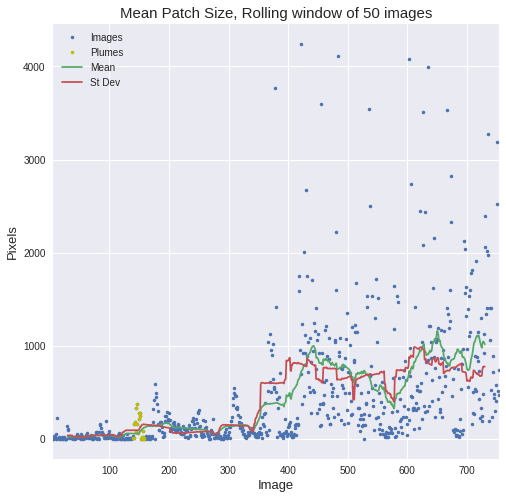

In [1336]:
unsmooth = df['2nd_largest_patch']

smooth = unsmooth.rolling(window = 50, center = True, axis = 0).mean()
smooth_sd = unsmooth.rolling(window = 50, center = True, axis = 0).std()

final = pd.DataFrame({'unsmooth':unsmooth, 'smooth':smooth, 'smooth_std':smooth_sd})
    
ax = final.unsmooth.plot(figsize = (8,8), linestyle = 'none', marker = '.')
final.unsmooth[135:155].plot(ax = ax, marker = '.', linestyle = 'none', c = 'y')
       
final[['smooth', 'smooth_std']].plot(ax = ax)
        
plt.title('Mean Patch Size, Rolling window of 50 images', size = 15)
plt.legend(['Images', 'Plumes', 'Mean','St Dev'], loc = 2)
plt.ylabel('Pixels', size = 13)
plt.xlabel('Image', size = 13)
plt.savefig('output_imgs/m3sd_w50_patchsize_roll.pdf')

In [1339]:
y_smooth = smooth(unsmooth.values)
#y_smooth.mean()

TypeError: 'Series' object is not callable

In [ ]:
#unsmooth2 = df['mean_patch_size']
#smooth2 = unsmooth2.rolling(window = 100, center = False, axis = 0).mean()
#smooth2_std = unsmooth2.rolling(window = 100, center = False, axis = 0).std()
#final2 = pd.DataFrame({'unsmooth':unsmooth2, 'smooth':smooth2, 'smooth_std':smooth2_std})
#ax2 = final2.unsmooth.plot(figsize = (8,8), linestyle = 'none', marker = '.')
#final2[['smooth', 'smooth_std']].plot(ax = ax2)
#final2.unsmooth[135:155].plot(ax = ax2, marker = '.', linestyle = 'none', c = 'y')

#plt.title('Mean Patch Size, Rolling Window 100 images', size = 15)
#plt.ylabel('Mean Number of pixels', size = 13)
#plt.xlabel('Image', size = 13)
#plt.legend(['Images', 'Mean', 'St Dev', 'Plumes'], loc = 2)
#plt.savefig('rmean2_m5sd.pdf')

In [1300]:
roll_and_plot('output_csvs/m3sd','mean_patch_size', plot = True, window = 5)

TypeError: roll_and_plot() got multiple values for keyword argument 'window'

In [ ]:
roll_and_plot('m3sd','2nd_largest_patch', plot = True)

In [ ]:
hist(tmp2.flatten(), normed = True, log = True)
axvline(np.mean(tmp2) + 4.*np.std(tmp2), c = 'r')

In [ ]:
#ls1 = tmp.iloc[0,135:155]
#ls2 = tmp.iloc[1,135:155]
#ls3 = tmp.iloc[2,135:155]
#ls4 = tmp.iloc[3,135:155]
#ls5 = tmp.iloc[4,135:155]
#ls6 = tmp.iloc[5,135:155]
    
#tmp_2 = [ls1,ls2,ls3,ls4,ls5,ls6]
#plumes = pd.DataFrame(tmp)
##plumes.head()

In [ ]:
#tmp2 = rebin(imgs[140], (imgs[139].shape[0]/4, imgs[139].shape[1]/4))

#imgtmp = tmp2.copy()


#imgtmp[tmp2<np.mean(tmp2) + 5.*np.std(tmp2)]=0
#imgtmp[imgtmp>0]=1

#labels, n_features = ndimage.measurements.label(imgtmp)

#labelsize = np.array([(labels==i).sum() for i in range(labels.max()+1)])

#labs = np.unique(labelsize)
#labdiff = np.diff(labs)

#print len(labs),",",np.max(labdiff),',',(labdiff>=50).sum(),',',n_features,',', np.mean(labdiff[:-1])

In [ ]:
# filter the images based on log-histogram. 

#from skimage import color

#th = 10  #7, 10
#for i in range(nimgs):
    #img_filt[i][img_filt[i] < th] = 0.0
#    imgbw[i] = color.rgb2gray(img_tmp[i]) #set images to grayscale

In [ ]:
#First plot of image with plume as example
#fig = figure(figsize = (13,11))
#imshow(imbin[140], cmap = 'viridis')
#axis('off')
#grid(False)

## Zoom into the different plumes and create histograms to see the behaviour

In [ ]:
#Zoom into the plume to see how well defined it is after filtering
#imshow(imgbw[1], cmap = 'viridis')

In [ ]:
#Histogram of the zoomed area
#hist(imgbw[12,800:900, 2000:2200].flatten(), log = True)
#hist(imgbw[12,810:865, 2000:2075].flatten(), alpha = 0.6)

In [ ]:
#imshow(imgbw[16,590:750, 1950:2050], cmap = 'viridis')

In [ ]:
#hist(imgbw[16,590:750, 1950:2050].flatten(), log = True)

In [ ]:
#imshow(img_filt[17,400:800, 1700:2200], cmap = 'viridis')

In [ ]:
#hist(img_filt[17,400:800, 1700:2200].flatten(), log = True)

In [ ]:
#imshow(img_filt[18,400:650, 2000:2300], cmap = 'viridis')

In [ ]:
#hist(img_filt[18,400:650, 2000:2300].flatten())

In [ ]:
#imshow(img_filt[19,200:600, 2000:2500], cmap = 'viridis')

In [ ]:
#hist(img_filt[19,200:600, 2000:2500].flatten(), log = True)

In [ ]:
#imshow(img_filt[20,200:500, 2300:2700], cmap = 'viridis')

In [ ]:
#hist(img_filt[20,200:500, 2300:2700].flatten(), log = True)

In [ ]:
#BINS = 50#int(round(2*len(img_med[0].flatten())**(1./3.)))
#y_md = np.zeros((nimgs, BINS))
#y_mn = np.zeros((nimgs, BINS))
#x = np.zeros(BINS)
#patches = np.zeros(BINS) #third element of histogram tuple NOT USED


#for i in range(nimgs):    
    #y_md[i], x, patches = plt.hist(img_tmp[i].flatten(), bins = BINS, log = True)
    #y_mn[i] = plt.hist(imgs_min[i].flatten(), bins = BINS, log = True)[0]

In [ ]:
#ymd_log = np.log10(y_md)

In [ ]:
#ymd_log[np.isinf(ymd_log)] = 0.0

In [ ]:
#bins_cen = x[:-1] + 0.5*(x[1]-x[0])

In [ ]:
#cols = ['img%d'%(i) for i in range(nimgs)]

#median_data = pd.DataFrame(ymd_log.T, columns = cols)
#median_data.insert(0, 'X', bins_cen)

## Histogram of oriented gradients

Documentation: http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html


In [ ]:

#from skimage.feature import hog

#test, hogimg = hog(imgbw[15], orientations = 10, pixels_per_cell=(16, 16), 
 #                  cells_per_block=(4,4), visualise=True, block_norm='L1')

In [ ]:
#figure(figsize = (12, 10))
#imshow(hogimg, cmap = 'viridis')
#grid(False)

In [ ]:
#imshow(hogimg[580:780, 1800:2200], cmap = 'viridis')
#grid(False)

## Sobel filtering to detect edges of plumes

In [ ]:
from skimage import filters
#edg1 = filters.sobel(imgbw[15])

In [ ]:
#figure(figsize = (12, 10))
#imshow(edg1, cmap = 'viridis')
#grid(False)

In [ ]:
#imshow(edg1[580:780, 1800:2200], cmap = 'viridis')

In [ ]:
#hist(edg1.flatten(), log = True)

In [ ]:
#edges = np.empty_like(imgbw)
#for i in range(nimgs):
#    edges[i] = filters.sobel(imgbw[i])


Making binary images based on filtering the brightness differences.

In [ ]:
#label = np.zeros(nimgs)
#imbin = np.empty_like(imgbw)
#imvar = np.zeros(nimgs)
#for i in range(nimgs):
#    imbin[i] = np.where(imgbw[i] > 10, 1.0, 0.0)
#    imvar[i] = imbin[i].sum()
#    if imvar[i] > 1877 and imvar[i] < 40000:
#        label[i] = 1.
    #print i, imvar[i]

In [ ]:
#figure(figsize = (12, 12))
#imshow(imbin[141], cmap = 'viridis')
#title('Block Image with plume', size = 14)
#axis('off')
#grid(False)


In [ ]:
#label

In [ ]:
#blk = np.zeros((nimgs, 50, 128))
#lbl = np.zeros(nimgs)
#for k in range(nimgs):
#    for i, x in enumerate(xrange(0,imbin[k].shape[0],26)):
#        for j, y in enumerate(xrange(0,imbin[k].shape[1],32)):
#            view = imbin[k,x:x+26, y:y+32]
#            blk[k,i,j] = np.where(view.sum() > 130, 1., 0.)
#            if blk[k].sum() >= 2. and blk[k].sum() < 30:
#                lbl[k] = 1.

In [ ]:
#t = np.zeros(nimgs/10)
#v = np.empty_like(t)
#for i, j in enumerate(xrange(0, nimgs, 10)):
#    v[i] = imvar[j:j+10].var()
 #   t[i] = i

In [ ]:
#t2 = np.arange(750)
#figure(figsize = (12, 8))
#plot(t2,imvar)
#plot(t2[137:149],imvar[137:149], color = 'r')
#xlabel('Image number', size = 15)
#ylabel('Number of Active Pixels (1s)', size = 15)
#title('Time series of active pixels', size = 18)
#legend(['no plume', 'plume'])

In [ ]:

#figure(figsize = (12, 8))
#plot(t2,np.log10(imvar))
#plot(t2[137:148],np.log10(imvar[137:148]), color = 'r')
#xlabel('Image number', size = 15)
#ylabel('Log10 of Number of Active Pixels (1s)', size = 15)
#title('Time series of active pixels (Log Scale)', size = 18)
#legend(['no plume', 'plume'])

In [ ]:
#figure(figsize = (10,8))
#plot(t,v)
#plot(t[13:16],v[13:16], color = 'r')
#xlabel('Image Group Number', size = 15)
#ylabel('Variance of Number of Active Pixels (1s)', size = 15)
#title('Time series of variance of active pixels', size = 18)
#legend(['no plume', 'plume'])

In [ ]:
#figure(figsize = (10,8))
#plot(t,np.log10(v))
#plot(t[14:16],np.log10(v[14:16]), color = 'r')
#xlabel('Image Group Number', size = 15)
#ylabel('Log of Variance of Number of Active Pixels (1s)', size = 15)
#title('Time series of variance of active pixels (Log scale)', size = 18)
#legend(['no plume', 'plume'])